In [10]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [11]:
env = BlackjackEnv()

In [12]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        max_action = np.argmax(Q[observation])
        A = np.ones(nA, dtype = float)
        A = A*epsilon/nA
        A[max_action] = A[max_action] + 1.0 - epsilon
        
        return A
    
    return policy_fn

In [13]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        episode = []
        state = env.reset()
        
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(len(probs), p = probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            else:
                state = next_state
                
                
        states = set([(tuple(x[0]),x[1]) for x in episode])
        
        for state,action in states:
            pair = (state, action)
            id_ = next(i for i,x in enumerate(episode) if x[0]==state and x[1]==action)
            g = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[id_:])])
            returns_sum[pair] += g
            returns_count[pair] += 1.0
            Q[state][action] = returns_sum[pair]/returns_count[pair]
            
            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            
    return Q, policy

In [16]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=50000, epsilon=0.1)

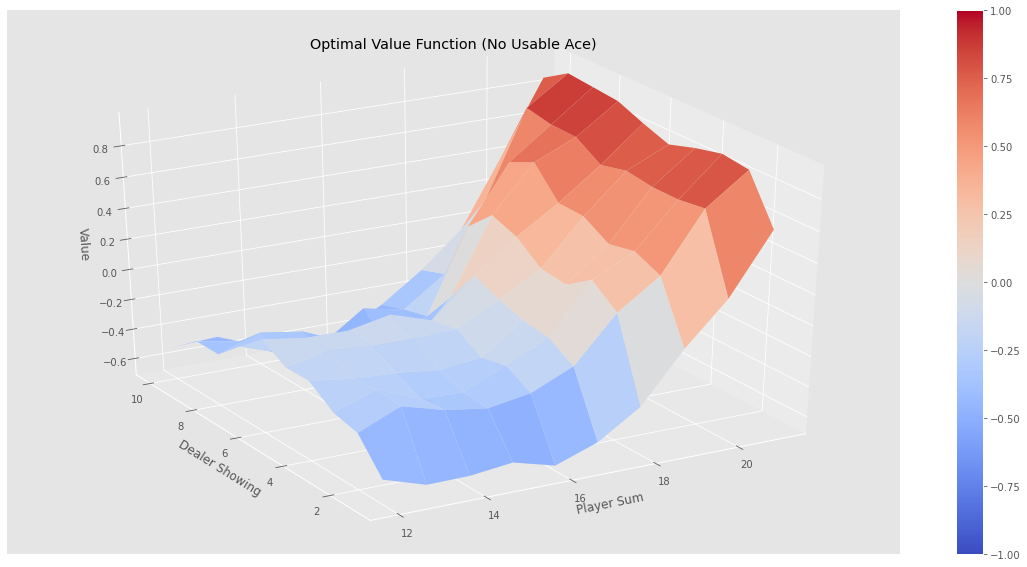

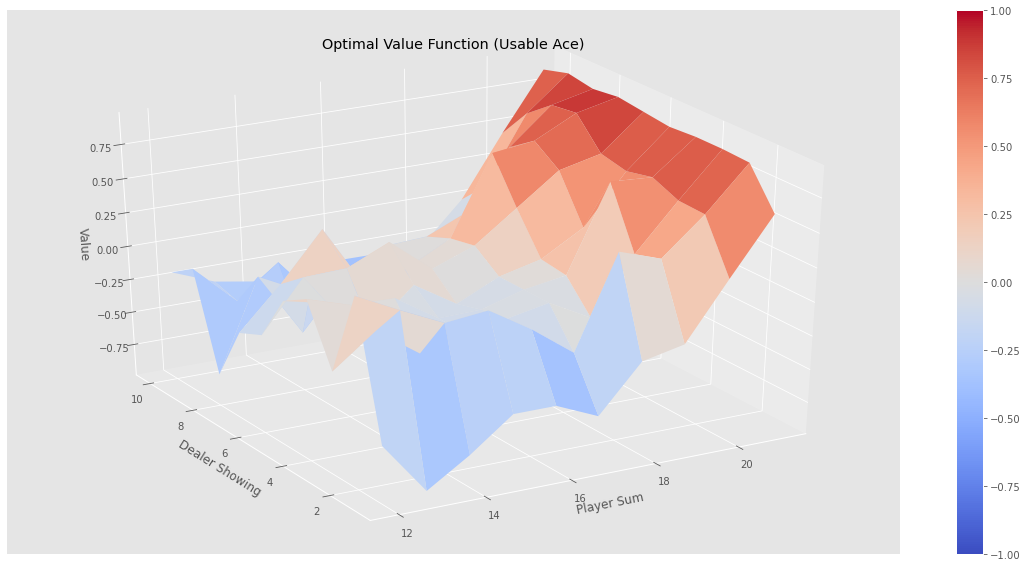

In [17]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")